# Script principal - George au JORF
Ce notebook présente les résultats de nos travaux sur les structures sociales et de genre au sein des cabinets ministériels. Celui-ci fait appel à deux autres scripts :
- requete_JORF.ipynb : obtention d'une base de données des nominations en cabinet en 2024
- (@Pierre)

### Table des matières
1) Récupération des données

- Nominations au JORF
- Prénoms et moyennes au bac

2) Statistiques descriptives

3) Modélisations


# 1. Récupération des données
## 1.A Nominations au Journal officiel de la République française
### Proof of concept : notre data frame constitué grâce à l'API Légifrance
Le tableau suivant est obtenu grâce au script [requete_JORF.ipynb].

In [7]:
!pip install unidecode

In [8]:
import s3fs
import pandas as pd
import numpy as np

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "sachanassensae"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/nominations_2024.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    df_nominations_2024 = pd.read_csv(file_in)

df_nominations_2024.head

<bound method NDFrame.head of    Genre      Prénom             Nom  \
0    Mme      Sabine         HAMMOND   
1    Mme  Marie-Anne        LAVERGNE   
2    Mme   Madeleine           ROUOT   
3    Mme       Anais  KEITA-GORISSEN   
4    Mme       Sarah           ALLIX   
..   ...         ...             ...   
86   Mme      Samira           Jemaï   
87   Mme       Chloé          Muller   
88   Mme      Margot          Provot   
89    M.      Jérémy        HERROUIN   
90    M.      Amaury           DUMAY   

                                                Titre     Date de début  \
0   conseillère technique en charge des discours (...   2 décembre 2024   
1   conseillère services financiers et économie in...  24 novembre 2024   
2   conseillère technique en charge de l'argumentaire  12 novembre 2024   
3                        conseillère technique presse  28 novembre 2024   
4   conseillère territoires et services publics au...  18 novembre 2024   
..                                     

Puis, avec JORFSEARCH (poursuivre ici)

In [9]:
import requests
import pandas as pd

## 1.1 Fetching the JSON data
# URL to Nathann Cohen's website. Filters : cabinet, JSON
json_url = "https://jorfsearch.steinertriples.ch/tag/cabinet?format=JSON"

# Fetch the JSON data from the URL
response = requests.get(json_url)
if response.status_code == 200:
    # Save the JSON data to a local file
    with open("nominations.json", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("JSON data downloaded and saved to 'nominations.json'.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


## 2. Converting it to a working panda
with open("nominations.json", "r", encoding="utf-8") as file:
    data = pd.read_json(file)

nominations = pd.DataFrame(data)
print(nominations.head())

JSON data downloaded and saved to 'nominations.json'.
                                       organisations source_date  \
0  [{'nom': 'Préfecture du Vaucluse', 'wikidata_i...  2024-12-18   
1  [{'nom': 'Préfecture du Vaucluse', 'wikidata_i...  2024-12-18   
2  [{'nom': 'Cabinet du Premier ministre', 'wikid...  2024-12-18   
3  [{'nom': 'Cabinet du Premier ministre', 'wikid...  2024-12-18   
4  [{'nom': 'Cabinet du Premier ministre', 'wikid...  2024-12-18   

              source_id source_name               type_ordre sous-prefet  \
0  JORFTEXT000050789652        JORF               nomination        true   
1  JORFTEXT000050789650        JORF    cessation de fonction         NaN   
2  JORFTEXT000050789616        JORF               nomination         NaN   
3  JORFTEXT000050789264        JORF  délégation de signature         NaN   
4  JORFTEXT000050789264        JORF  délégation de signature         NaN   

                                 cabinet sexe           nom           prenom  \


In [10]:
## 1.3 Filtres afin de ne conserver que les cabinets ministériels
print(nominations.columns)

# Unique values and their counts for 'type_ordre'
type_ordre_counts = nominations['type_ordre'].value_counts()
print("Unique values in 'type_ordre' and their counts:")
print(type_ordre_counts)

# Unique values and their counts for 'cabinet_ministeriel'
cabinet_ministeriel_counts = nominations['cabinet_ministeriel'].value_counts()
print("\nUnique values in 'cabinet_ministeriel' and their counts:")
print(cabinet_ministeriel_counts)


nominations_ministerielles = nominations[
    (nominations['cabinet_ministeriel'].isna() != True) &
    (nominations['type_ordre'] == 'nomination')
]

cessations = nominations[
    (nominations['cabinet_ministeriel'].isna() != True) &
    (nominations['type_ordre'] == 'cessation de fonction')
]

# 1.4 Premiers comptes
total_nominations_ministerielles = len(nominations_ministerielles)
total_cessations = len(cessations)

# Convert 'source_date' to datetime
nominations_ministerielles['source_date'] = pd.to_datetime(nominations_ministerielles['source_date'], errors='coerce')
cessations['source_date'] = pd.to_datetime(cessations['source_date'], errors='coerce')

# Counts per year
nominations_ministerielles_per_year = nominations_ministerielles['source_date'].dt.year.value_counts().sort_index()
cessations_per_year = cessations['source_date'].dt.year.value_counts().sort_index()

# Display results
print("Total Nominations Ministerielles:", total_nominations_ministerielles)
print("Total Cessations:", total_cessations)
print("Nominations Ministerielles Per Year:\n", nominations_ministerielles_per_year)
print("Cessations Per Year:\n", cessations_per_year)



Index(['organisations', 'source_date', 'source_id', 'source_name',
       'type_ordre', 'sous-prefet', 'cabinet', 'sexe', 'nom', 'prenom',
       'a_sa_demande', 'grade', 'cabinet_ministeriel', 'autorite_delegation',
       'date_debut', 'date_fin', 'ecole', 'parlement', 'duree', 'suppleant',
       'remplacement', 'prefet', 'secretaire_general_de_prefecture',
       'sous-prefet_sous-prefecture', 'sous-prefecture_departement_code',
       'visa_emploi_superieur', 'conseil_des_ministres', 'autres_prenoms',
       'conseil_administration', 'inspecteur_general', 'membre_gouvernement',
       'ministre', 'tribunal', 'depart_retraite',
       'conseiller_affaire_etrangeres', 'ambassadeur',
       'ambassadeur_thematique', 'cour_comptes', 'magistrat', 'nom_alternatif',
       'corps', 'tribunal_administratif', 'maitre_de_conference',
       'tribunal_grande_instance', 'secretaire_affaires_etrangeres'],
      dtype='object')
Unique values in 'type_ordre' and their counts:
type_ordre
nominati

/tmp/ipykernel_182904/3816085935.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominations_ministerielles['source_date'] = pd.to_datetime(nominations_ministerielles['source_date'], errors='coerce')
/tmp/ipykernel_182904/3816085935.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cessations['source_date'] = pd.to_datetime(cessations['source_date'], errors='coerce')


In [11]:
## Enrichissons de la couleur politique ! 

import pandas as pd

# Data for French Prime Ministers from 1990 to 2024
data = {
    'PM': [
        'Michel Rocard', 'Édith Cresson', 'Pierre Bérégovoy', 'Édouard Balladur',
        'Alain Juppé', 'Lionel Jospin', 'Jean-Pierre Raffarin', 'Dominique de Villepin',
        'François Fillon', 'Jean-Marc Ayrault', 'Manuel Valls', 'Bernard Cazeneuve',
        'Édouard Philippe', 'Jean Castex', 'Élisabeth Borne', 'Gabriel Attal', 'Michel Barnier'
    ],
    'Start Date': [
        '1988-05-10', '1991-05-15', '1992-04-02', '1993-03-29',
        '1995-05-17', '1997-06-02', '2002-05-06', '2005-05-31',
        '2007-05-17', '2012-05-15', '2014-03-31', '2016-12-06',
        '2017-06-21', '2020-07-03', '2022-05-16', '2024-01-11', '2024-09-05'
    ],
    'End Date': [
        '1991-05-15', '1992-04-02', '1993-03-29', '1995-05-17',
        '1995-11-07', '2002-05-06', '2005-05-31', '2007-05-17',
        '2012-05-15', '2014-03-31', '2016-12-06', '2017-05-15',
        '2020-07-03', '2022-05-16', '2024-01-08', '2024-09-05', None  # None indicates incumbent
    ],
    'Party': [
        'PS', 'PS', 'PS', 'RPR',
        'RPR', 'PS', 'UMP', 'UMP',
        'UMP', 'PS', 'PS', 'PS',
        'LREM', 'LREM', 'LREM', 'LREM', 'LR'
    ],
    'Alignment': [
        'Left', 'Left', 'Left', 'Right',
        'Right', 'Left', 'Right', 'Right',
        'Right', 'Left', 'Left', 'Left',
        'Center-right', 'Center-right', 'Center-right', 'Center-right', 'Right'
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert 'Start Date' and 'End Date' to datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

# Display the DataFrame
print(df)


                       PM Start Date   End Date Party     Alignment
0           Michel Rocard 1988-05-10 1991-05-15    PS          Left
1           Édith Cresson 1991-05-15 1992-04-02    PS          Left
2        Pierre Bérégovoy 1992-04-02 1993-03-29    PS          Left
3        Édouard Balladur 1993-03-29 1995-05-17   RPR         Right
4             Alain Juppé 1995-05-17 1995-11-07   RPR         Right
5           Lionel Jospin 1997-06-02 2002-05-06    PS          Left
6    Jean-Pierre Raffarin 2002-05-06 2005-05-31   UMP         Right
7   Dominique de Villepin 2005-05-31 2007-05-17   UMP         Right
8         François Fillon 2007-05-17 2012-05-15   UMP         Right
9       Jean-Marc Ayrault 2012-05-15 2014-03-31    PS          Left
10           Manuel Valls 2014-03-31 2016-12-06    PS          Left
11      Bernard Cazeneuve 2016-12-06 2017-05-15    PS          Left
12       Édouard Philippe 2017-06-21 2020-07-03  LREM  Center-right
13            Jean Castex 2020-07-03 2022-05-16 

In [12]:
## On apparie les deux bases

# Ensure 'date_debut' in nominations_ministerielles is in datetime format
nominations_ministerielles['date_debut'] = pd.to_datetime(nominations_ministerielles['date_debut'], errors='coerce')

# Perform a cross join to compare every row in nominations_ministerielles with every row in df
nominations_with_political_alignment = nominations_ministerielles.assign(key=1).merge(
    df.assign(key=1), on='key'
).drop('key', axis=1)

# Filter rows where 'date_debut' falls between 'Start Date' and 'End Date'
nominations_with_political_alignment = nominations_with_political_alignment[
    (nominations_with_political_alignment['date_debut'] >= nominations_with_political_alignment['Start Date']) &
    (nominations_with_political_alignment['date_debut'] <= nominations_with_political_alignment['End Date'])
]

# Drop unnecessary columns and reset index for cleaner results
nominations_with_political_alignment = nominations_with_political_alignment.drop(
    ['Start Date', 'End Date'], axis=1
).reset_index(drop=True)

# Display the merged DataFrame
print(nominations_with_political_alignment)


/tmp/ipykernel_182904/462788230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominations_ministerielles['date_debut'] = pd.to_datetime(nominations_ministerielles['date_debut'], errors='coerce')


     organisations source_date             source_id source_name  type_ordre  \
0               []  2024-08-30  JORFTEXT000050148223        JORF  nomination   
1               []  2024-08-24  JORFTEXT000050133926        JORF  nomination   
2               []  2024-07-31  JORFTEXT000050060447        JORF  nomination   
3               []  2024-07-18  JORFTEXT000050011569        JORF  nomination   
4               []  2024-07-13  JORFTEXT000049963270        JORF  nomination   
...            ...         ...                   ...         ...         ...   
4719            []  1990-05-23  JORFTEXT000000159814        JORF  nomination   
4720            []  1990-05-23  JORFTEXT000000159814        JORF  nomination   
4721            []  1990-05-15  JORFTEXT000000708891        JORF  nomination   
4722            []  1990-04-20  JORFTEXT000000349222        JORF  nomination   
4723            []  1990-03-24  JORFTEXT000000349503        JORF  nomination   

     sous-prefet                       

Nous avons moins de cessation que de nominations : il n'est pas certain que ces données soient homogènes, donc nous allons rester sur les nominations. 

## 1.B Prénoms et moyenne au bac
### 1.B.1 Données 2024 obtenues par scraping

Dans cette sous partie nous allons traiter les données obtenues par scraping grâce au script scraping_bac.ipynb.



On commence par le récupérer dans le Bucket.

In [13]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "pripoll"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/tab_mentions.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    tab = pd.read_csv(file_in).loc[:,"prenom":"mention"]

Nous avons donc récupéré le tableau tab_mentions. Nous allons maintenant lui faire subir des traitements pour calculer un score social.

In [14]:
## tab est le tableau tab_mentions


### On ne garde que le premier prénom

#prem_pren = tab.prenom
#for i in range(len(prem_pren)):
#  prem_pren[i]=prem_pren[i].split()[0]
#tab.prenom = prem_pren

def premm(word):
  return word.split()[0]

tab.prenom = tab.prenom.apply(premm)

### On crée d'abord des indicatrices pour les mentions
tab["Nombre"] = [1]*len(tab)
tab["Admis"] = [0]*len(tab)
tab["AB"] = [0]*len(tab)
tab["B"] = [0]*len(tab)
tab["TB"] = [0]*len(tab)
tab.loc[tab.mention == "Admis ", "Admis"] = 1
tab.loc[tab.mention == 'Admis mention AB', "AB"] = 1
tab.loc[tab.mention == 'Admis mention Bien', "B"] = 1
tab.loc[tab.mention == 'Admis mention TB', "TB"] = 1

test = tab.groupby(by=["prenom"]).sum()

## On va maintenant faire les pourcentages de mention (exprimé en faction e 1)

test["Admis"] = test["Admis"]/test["Nombre"]
test["AB"] = test["AB"]/test["Nombre"]
test["B"] = test["B"]/test["Nombre"]
test["TB"] = test["TB"]/test["Nombre"]

test = test[test.Nombre>3]

test["Score"] = test["Admis"]*11 + test["AB"]*13 + test["B"]*15 + test["TB"]*18

test.to_csv("tab_mentions_score.csv")

test

academie  \
prenom                                                        
aaliyah   lillemontpelliernormandienormandienormandiepar...   
aaron     aix-marseilleaix-marseilleaix-marseilleaix-mar...   
abby      lyonnancy-metznormandieparis-creteil-versaille...   
abdallah  dijonlyonnancy-metznancy-metznantespoitiersrennes   
abdel     aix-marseilleaix-marseilleaix-marseilleamiensb...   
...                                                     ...   
émilien   amiensamiensbordeauxgrenobleguyanelillelyonnan...   
émy                  bordeauxclermont-ferrandlyonnancy-metz   
énora                             grenoblelimogeslyonrennes   
étienne            aix-marseillelyonnormandiepoitiersrennes   
éva       bordeauxbordeauxbordeauxbordeauxclermont-ferra...   

                                                      ville  \
prenom                                                        
aaliyah   st amand les eauxnarbonnevire normandiele havr...   
aaron     marseillemarseillearlesmarseille  8orangelons ...   
abby      roannebar le ducfecampvillepreuxhennebontrenne...   
abdallah  montceau les minesst priest en jarezmetzvandoe...   
abdel     marseillemarseille  10martiguesperonnepessacde...   
...                                                     ...   
émilien   amiensamienslibourneromans sur isereremire mon...   
émy            bordeauxchamalieresbourg-en-bresseremiremont   
énora                           meylanst junienlyonbrest  9   
étienne   digne les bains  9chazelles sur lyoncaen  05br...   
éva       gujan-mestrassarlat la canedast vincent de tyr...   

                                                    mention  Nombre     Admis  \
prenom                                                                          
aaliyah   Admis mention BienAdmis Admis mention TBAdmis ...       8  0.500000   
aaron     Admis mention BienAdmis mention BienAdmis ment...      59  0.305085   
abby      Admis Admis mention ABAdmis mention BienAdmis ...       6  0.333333   
abdallah  Admis Admis Admis mention BienAdmis mention AB...       7  0.428571   
abdel     Admis mention ABAdmis Admis Admis Admis Admis ...       8  0.625000   
...                                                     ...     ...       ...   
émilien   Admis mention ABAdmis mention BienAdmis mentio...      11  0.090909   
émy       Admis Admis mention ABAdmis mention BienAdmis ...       4  0.250000   
énora     Admis mention BienAdmis mention TBAdmis mentio...       4  0.000000   
étienne   Admis mention BienAdmis Admis mention TBAdmis ...       5  0.200000   
éva       Admis mention BienAdmis mention ABAdmis mentio...      13  0.076923   

                AB         B        TB      Score  
prenom                                             
aaliyah   0.125000  0.250000  0.125000  13.125000  
aaron     0.305085  0.288136  0.101695  13.474576  
abby      0.333333  0.333333  0.000000  13.000000  
abdallah  0.142857  0.428571  0.000000  13.000000  
abdel     0.375000  0.000000  0.000000  11.750000  
...            ...       ...       ...        ...  
émilien   0.181818  0.363636  0.363636  15.363636  
émy       0.250000  0.500000  0.000000  13.500000  
énora     0.250000  0.250000  0.500000  16.000000  
étienne   0.200000  0.200000  0.400000  15.000000  
éva       0.461538  0.230769  0.230769  14.461538  

[2883 rows x 9 columns]

### 1.B.2 Données scrapées sur plusieurs années

Dans cette partie, nous allons exploiter les données collectées sur plusieurs années, par la même méthode de scraping, par M. Baptiste Coulmon. Il a accepté de nous fournir ses données.

On commence par récupérer ces données dans un Bucket

In [15]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "pripoll"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/bac_ripoll.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    tab_coul = pd.read_csv(file_in).loc[:,"prenom":"total"]

In [16]:
## tab_coul est le fichier brut fourni par M. Coulmon


### Calculons le score social, et uniformisons avec le format 

tab_coul= tab_coul.pivot(columns= "mention", values = "N",index=["prenom","total"]).reset_index()
tab_coul.columns = ["prenom","Nombre","nan","AB","B","Oral","Admis","SDF","TB"]
tab_coul = tab_coul.drop(["nan","SDF"], axis=1)
tab_coul = tab_coul.fillna(0)
tab_coul["Score"] = (tab_coul["Admis"]*11+tab_coul["Oral"]*9+tab_coul["AB"]*13+tab_coul["B"]*15+tab_coul["TB"]*18)/tab_coul["Nombre"]

tab_coul = tab_coul.loc[pd.isnull(tab_coul.prenom)==False,:]

tab_coul = tab_coul[tab_coul.Nombre >30]
tab_coul = tab_coul.iloc[1:]

tab_coul.to_excel("tab_mentions_score_coul.xlsx")

tab_coul

prenom  Nombre      AB       B   Oral   Admis      TB      Score
1         Aaron     247    65.0    30.0   44.0    89.0    19.0  12.194332
2      Abdallah     212    47.0    21.0   63.0    71.0    10.0  11.575472
3         Abdel     251    45.0    20.0   85.0    97.0     4.0  11.111554
4     Abdelaziz     103    16.0     7.0   26.0    51.0     3.0  11.281553
5      Abdelhak      40     6.0     3.0   15.0    14.0     2.0  11.200000
...         ...     ...     ...     ...    ...     ...     ...        ...
3505   Zinedine     258    55.0    29.0   59.0   110.0     5.0  11.554264
3506      Ziyad      53     8.0     9.0   12.0    20.0     4.0  12.056604
3507        Zoe    6775  1936.0  1611.0  467.0  1520.0  1239.0  13.661697
3508      Zohra     214    47.0    28.0   50.0    78.0    11.0  11.855140
3509       Zora      62    19.0    10.0    4.0    18.0    11.0  13.370968

[3509 rows x 8 columns]

# 2. Statistiques descriptives
## 2.1 Evolutions du nombre de nominations

/tmp/ipykernel_182904/1021414675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominations_ministerielles['source_date'] = pd.to_datetime(nominations_ministerielles['source_date'], errors='coerce')
/tmp/ipykernel_182904/1021414675.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)  # Add the legend


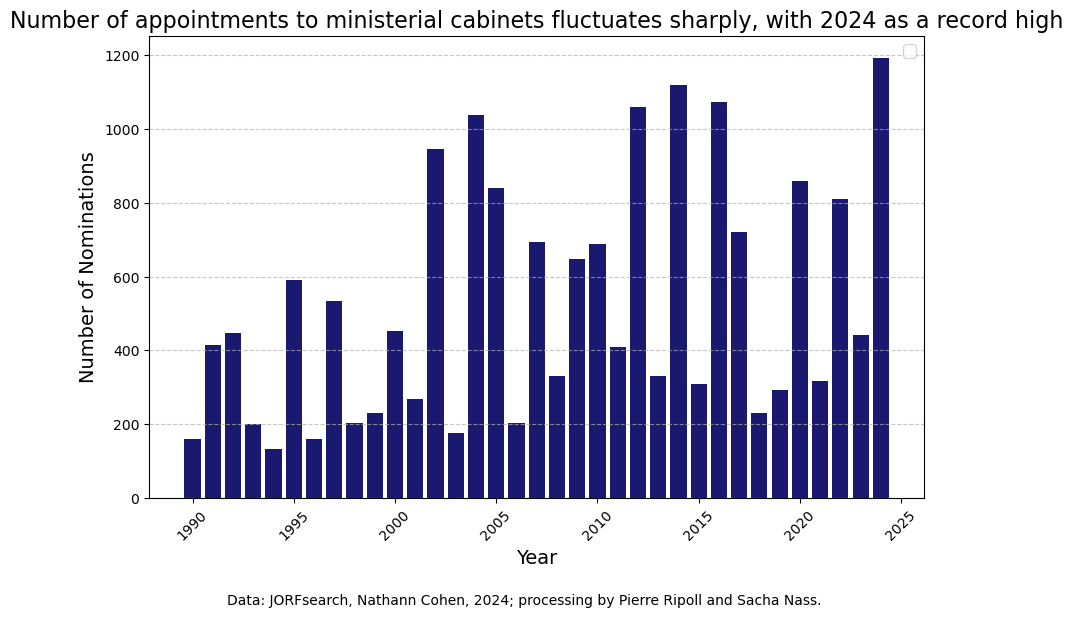

In [17]:
import matplotlib.pyplot as plt

# Ensure 'source_date' is in datetime format
nominations_ministerielles['source_date'] = pd.to_datetime(nominations_ministerielles['source_date'], errors='coerce')

# Count nominations per year
nominations_per_year = nominations_ministerielles['source_date'].dt.year.value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(nominations_per_year.index, nominations_per_year.values, color='MidnightBlue')
plt.title("Number of appointments to ministerial cabinets fluctuates sharply, with 2024 as a record high", fontsize=16)
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05) 
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Nominations', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)  # Add the legend
plt.show()


## 2.2. Une féminisation des cabinets ministériels ... 

/tmp/ipykernel_182904/1540498185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominations_ministerielles['year'] = nominations_ministerielles['source_date'].dt.year


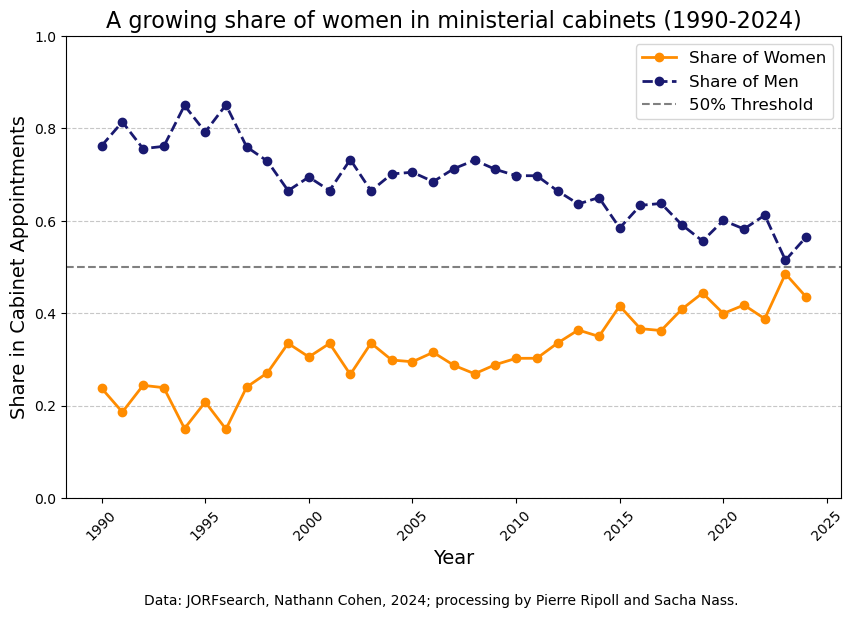

In [18]:
# Extract year and filter valid data
nominations_ministerielles['year'] = nominations_ministerielles['source_date'].dt.year
valid_nominations = nominations_ministerielles.dropna(subset=['year', 'sexe'])

# Calculate the share of 'F' and 'M' per year
shares_per_year = valid_nominations.groupby('year')['sexe'].value_counts(normalize=True).unstack(fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(shares_per_year.index, shares_per_year['F'], label="Share of Women", color='darkorange', marker='o', linestyle='-', linewidth=2)
plt.plot(shares_per_year.index, shares_per_year['M'], label="Share of Men", color='MidnightBlue', marker='o', linestyle='--', linewidth=2)

# Customize the plot
plt.title("A growing share of women in ministerial cabinets (1990-2024)", fontsize=16)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label="50% Threshold")
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)  
plt.xlabel('Year', fontsize=14)
plt.ylabel('Share in Cabinet Appointments', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Shares are between 0 and 1
plt.show()


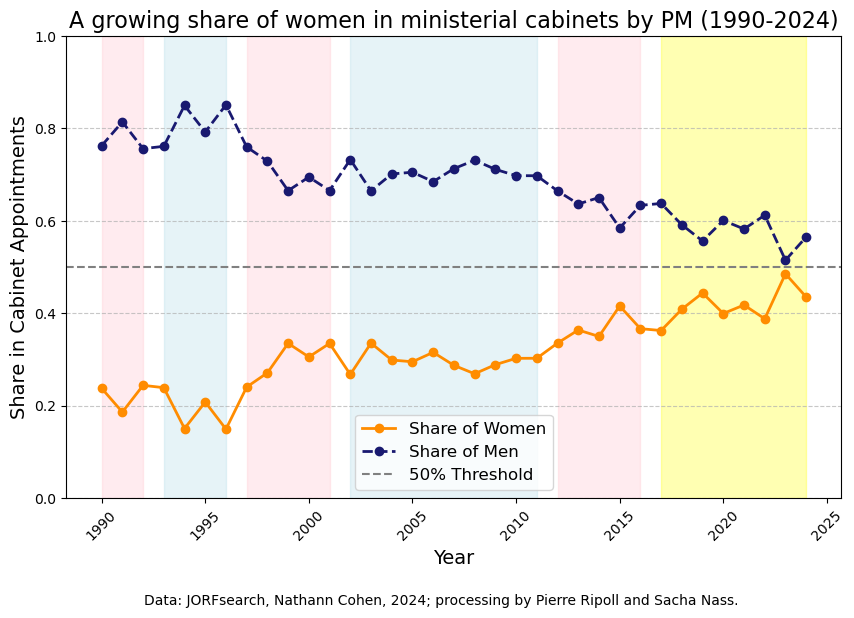

In [19]:
## La version par PM

# Extract year and filter valid data
nominations_with_political_alignment['year'] = nominations_with_political_alignment['source_date'].dt.year
valid_nominations = nominations_with_political_alignment.dropna(subset=['year', 'sexe','PM', 'Alignment'])

# Calculate the share of 'F' and 'M' per year
shares_per_year_pm = (
    valid_nominations.groupby(['year', 'PM'])['sexe']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

alignments = valid_nominations.groupby(['year', 'PM'])['Alignment'].first().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(shares_per_year.index, shares_per_year['F'], label="Share of Women", color='darkorange', marker='o', linestyle='-', linewidth=2)
plt.plot(shares_per_year.index, shares_per_year['M'], label="Share of Men", color='MidnightBlue', marker='o', linestyle='--', linewidth=2)

plt.axvspan(1990, 1992, color='pink', alpha=0.3)
plt.axvspan(1993, 1996, color='lightblue', alpha=0.3)
plt.axvspan(1997, 2001, color='pink', alpha=0.3)
plt.axvspan(2002, 2011, color='lightblue', alpha=0.3)
plt.axvspan(2012, 2016, color='pink', alpha=0.3)
plt.axvspan(2017, 2024, color='yellow', alpha=0.3)

# Customize the plot
plt.title("A growing share of women in ministerial cabinets by PM (1990-2024)", fontsize=16)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label="50% Threshold")
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)  
plt.xlabel('Year', fontsize=14)
plt.ylabel('Share in Cabinet Appointments', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Shares are between 0 and 1
plt.show()


## 2.3. Qui cache un plafond de verre ?

Unique values in 'grade':
['Conseiller' nan 'Directeur' 'Chef' 'Chef militaire' 'Directeur adjoint'
 'Chef adjoint']


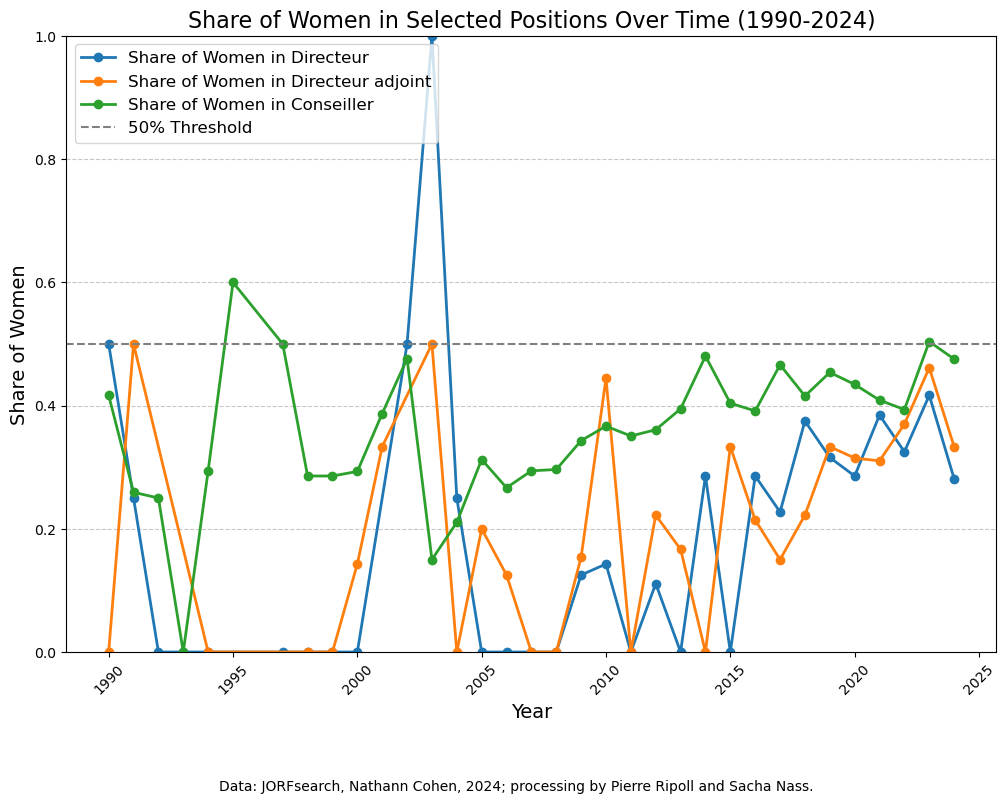

In [20]:
# Get all unique values of the 'grade' column
unique_grades = nominations_ministerielles['grade'].unique()
print("Unique values in 'grade':")
print(unique_grades)

grades_of_interest = ['Directeur', 'Directeur adjoint', 'Conseiller']

# Initialize a dictionary to store shares per year for each grade
shares_by_grade = {}

for grade in grades_of_interest:
    # Filter data for the current grade
    grade_data = valid_nominations[valid_nominations['grade'] == grade]
    
    # Calculate the share of women per year for the current grade
    shares_by_grade[grade] = (
        grade_data.groupby('year')['sexe']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        .get('F', 0)  # Get share of women ('F'), default to 0 if no women in a year
    )

# Plotting
plt.figure(figsize=(12, 8))

# Plot a line for each grade
for grade, shares in shares_by_grade.items():
    plt.plot(shares.index, shares, label=f"Share of Women in {grade}", marker='o', linewidth=2)

# Customize the plot
plt.title("Share of Women in Selected Positions Over Time (1990-2024)", fontsize=16)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label="50% Threshold")
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)  
plt.xlabel('Year', fontsize=14)
plt.ylabel('Share of Women', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Shares are between 0 and 1
plt.show()


## 2.3 Score moyen au bac des académies

Dans cette sous-partie nous allons exploiter les données du bac (scrapées, celles de M. Coulmon ne contienne pas d'informations spatiales).
Pour cela nous repartons du fichier brut. Nous le réimportons donc du Bucket.

Nous utilisons également les géo-data du ministère de l'éducation nationale pour obtenir les cartes des académies. Nous les importons également du Bucket

In [21]:
!pip install geopandas
import geopandas as gpd
### On va importe tous les fichiers

# Récupération des fichiers depuis MinIO vers la machine locale
MY_BUCKET = "pripoll"
fs.get(f"{MY_BUCKET}/diffusion/cartes/", "cartes/", recursive=True)

carte_0 = gpd.read_file("cartes")

Nous allons 

/tmp/ipykernel_182904/3839704577.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.047331676724648' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  carte_0_moy.loc[carte_0_moy.name == traduction(ac),"Moyenne"] = moy ## On met directe dans le géodata
/tmp/ipykernel_182904/3839704577.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  carte_0_moy.loc[carte_0_moy.name == "Académie de Rouen","Moyenne"] = float(carte_0_moy.loc[carte_0_moy.name == "Académie de Caen","Moyenne"])
/tmp/ipykernel_182904/3839704577.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  carte_0_moy.loc[carte_0_moy.name == "Académie de Créteil","Moyenne"] = float(carte_0_moy.loc[carte_0_moy.nam

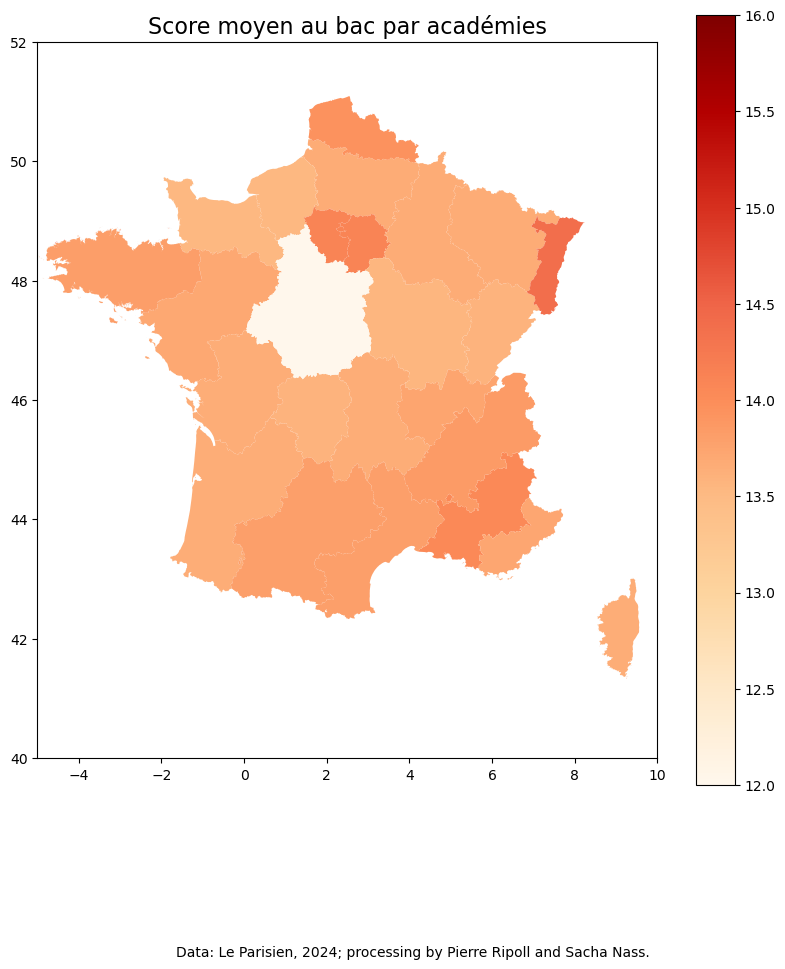

In [22]:
import matplotlib.pyplot as plt
acad = ["aix-marseille","amiens","besancon","bordeaux","clermont-ferrand","corse","dijon","grenoble","guyane","lille","limoges","lyon","martinique","mayotte","montpellier","nancy-metz","nantes","nice","normandie","orleans-tour","paris-creteil-versailles","poitiers","reims","rennes","reunion","strasbourg","toulouse"]


## tab est le fichié scrapé, carte_0 est le géo-dataframe.abs

#### Fonction de traduction
### On va ici faire une fonction de traduction pour passer d'une académie à une autre.
### La traduction prend academ une academie format bac et retourne académie format geopanda
def traduction(academ):
  i = ["aix-marseille","amiens","besancon","bordeaux","clermont-ferrand","corse","dijon","grenoble","guyane","lille","limoges","lyon","martinique","mayotte","montpellier","nancy-metz","nantes","nice","normandie","orleans-tour","paris-creteil-versailles","poitiers","reims","rennes","reunion","strasbourg","toulouse"].index(academ)
  return ["Académie d'Aix-Marseille","Académie d'Amiens","Académie de Besançon","Académie de Bordeaux","Académie de Clermont-Ferrand","Académie de Corse","Académie de Dijon","Académie de Grenoble","Académie de Guyane","Académie de Lille","Académie de Limoges","Académie de Lyon","Académie de la Martinique","Rien","Académie de Montpellier","Académie de Nancy-Metz","Académie de Nantes","Académie de Nice","Académie de Caen","Académie d'Orléans-Tours","Académie de Paris","Académie de Poitiers","Académie de Reims","Académie de Rennes","Académie de la Réunion","Académie de Strasbourg","Académie de Toulouse"][i]


##On commence par lire le fichier mentions
tableau_traitement = pd.read_csv("tab_mentions.csv")
## On va mettre un équivalent notes pour chaque mentions.
tableau_traitement["Note"] = [0]*len(tableau_traitement)
tableau_traitement.loc[tableau_traitement.mention == "Admis ","Note"] = [11]*len(tableau_traitement.loc[tableau_traitement.mention == "Admis ","Note"])
tableau_traitement.loc[tableau_traitement.mention == "Admis mention AB","Note"] = [13]*len(tableau_traitement.loc[tableau_traitement.mention == "Admis mention AB","Note"])
tableau_traitement.loc[tableau_traitement.mention == "Admis mention Bien","Note"] = [15]*len(tableau_traitement.loc[tableau_traitement.mention == "Admis mention Bien","Note"])
tableau_traitement.loc[tableau_traitement.mention == "Admis mention TB","Note"] = [18]*len(tableau_traitement.loc[tableau_traitement.mention == "Admis mention TB","Note"])


## On crée un tab deux colonnes
score = pd.DataFrame (columns = ["Academie","ScoreMoy"])

## on fait une boucle sur les académies pour aller calculer le score moyen
carte_0_moy = carte_0.copy()
carte_0_moy["Moyenne"] = [0]*len(carte_0)

for ac in acad :
  filtre = tableau_traitement.loc[tableau_traitement.academie ==ac,:]
  if len(filtre)!=0 :
    moy = sum(filtre.Note)/len(filtre)
    score.loc[len(score)]= [ac,moy] # On crée un tableau à part pour l'information
    carte_0_moy.loc[carte_0_moy.name == traduction(ac),"Moyenne"] = moy ## On met directe dans le géodata

## On fait des modif à la main : mettre rouen dans normandie, versailles dans Paris, et enlever les outres mer
carte_0_moy.loc[carte_0_moy.name == "Académie de Rouen","Moyenne"] = float(carte_0_moy.loc[carte_0_moy.name == "Académie de Caen","Moyenne"])
carte_0_moy.loc[carte_0_moy.name == "Académie de Créteil","Moyenne"] = float(carte_0_moy.loc[carte_0_moy.name == "Académie de Paris","Moyenne"])
carte_0_moy.loc[carte_0_moy.name == "Académie de Versailles","Moyenne"] = float(carte_0_moy.loc[carte_0_moy.name == "Académie de Paris","Moyenne"])

carte_0_moy = carte_0_moy.cx[-10:10,35:55]

# Créer un graphique
fig, ax = plt.subplots(figsize=(10, 10))
carte_0_moy.plot(ax=ax, column = 'Moyenne',cmap = "OrRd",vmin = 12, vmax = 16, legend = True,)
# Modifier les limites de la carte (changer la "portée" de l'affichage)
ax.set_xlim([-5, 10])   # Plage de longitude
ax.set_ylim([40, 52])  # Plage de latitude

plt.title("Score moyen au bac par académies", fontsize=16)
plt.suptitle("Data: Le Parisien, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)

# Afficher la carte
plt.show()


## 2.4 Représentativité des académies

Dans cette sous-partie nous allons produire un graphique qui traduit un score de représentativité des académies en matière de prénoms des cabinets ministériels.
Pour un prénom donné, on définit la "représentativité" de l'académie par : le nombre de personnes de ce prénom dans l'académie/nombre de personnes en tout qui ont ce prénom.
Le score agrégé sur tous les prénoms est la somme de ces proportions.

In [23]:
def minuscule(chaine):
    if not chaine:
        return chaine  # Retourne la chaîne telle quelle si elle est vide
    return chaine[0].lower() + chaine[1:]

def somme_vectorielle(liste1, liste2):
    # Vérifie que les deux listes ont la même longueur
    if len(liste1) != len(liste2):
        raise ValueError("Les listes doivent avoir la même longueur pour effectuer la somme vectorielle.")

    # Effectue la somme terme à terme
    resultat = [x + y for x, y in zip(liste1, liste2)]

    return resultat

In [ ]:
##Creation d'un df où on va stocker les scores de représentatitivité.
reprez = pd.DataFrame(columns= ["prenom"]+acad)

## On va remplir ce df en calculant le score pour chaque prénom
tab_reprez = pd.read_csv("tab_mentions.csv")
pren = np.unique(tab_reprez.prenom) ## liste de tous les prenoms.
reprez.prenom = pren ## on met la ligne
for preno in pren : ## Boucle sur les prénoms
  for ville in acad : ## On boucle sur toutes les académies
    reprez.loc[reprez.prenom == preno, ville] = len(tab_reprez.loc[tab_reprez.prenom == preno,:].loc[tab_reprez.academie == ville,:])/len(tab_reprez.loc[tab_reprez.prenom == preno,:])
reprez.to_csv("reprez.csv")


## Stockage du vecteur prénoms des nominés au jorf et création df avec colonne acad et coonne représentativité.
pren_jorf = np.unique(nominations_ministerielles.prenom)
reprez_acad = pd.DataFrame(columns = ["academie","representativite"])
reprez_acad.academie = acad # On met les acad de mentions

for preno in pren_jorf : # on fait une boucle sur les prenoms du fichier jorf.
  preno = minuscule(preno) ## on passe au format mentions
  if preno in pren :
    reprez_acad.representativite = somme_vectorielle(list(reprez_acad.representativite),list(reprez.loc[reprez.prenom == preno,acad[0]:acad[len(acad)-1]]))


## adjonction au geodataframe pour faire le graphique
carte_0_reprez = carte_0.copy()
carte_0_reprez["Representativite"] = [0]*len(carte_0_reprez)
for ac in acad :
  carte_0_reprez.loc[carte_0_reprez.name == traduction(ac),"Representativite"] = reprez_acad.loc[reprez.acad.academie == ac,"representativite"]


# Créer un graphique
fig, ax = plt.subplots(figsize=(10, 10))
carte_0_moy.plot(ax=ax, column = "Representativite", cmap ="Blues", legend = True)

# Modifier les limites de la carte (changer la "portée" de l'affichage)
ax.set_xlim([-5, 10])   # Plage de longitude
ax.set_ylim([40, 52])  # Plage de latitude

plt.title("Représentativité des cabinets ministériels dans les académies", fontsize=16)

# Afficher la carte
plt.show()

In [ ]:
## Dans cette partie on va optimiser le code

##Creation d'un df où on va stocker les scores de représentatitivité.
reprez = pd.DataFrame(columns= ["prenom"]+acad)

## On va remplir ce df en calculant le score pour chaque prénom
tab_reprez = pd.read_csv("tab_mentions.csv")
pren = np.unique(tab_reprez.prenom) ## liste de tous les prenoms.
reprez.prenom = pren ## on met la ligne

# 3. Modélisation

Dans cette partie nous allons procéder à la tentative de créer un lien empirique entre le score moyen d'un prénom, et la "probabilité" pour ce prénom d'aller dans un cabinet ministériel. Ce lien sera modélisé par une régression linéaire.
On prendra par la suite deux définitions différentes de cette probabilité, et on fera tourner ce script sur les données récoltées par M. Coulmon car, étant récoltées sur plusieurs années, permettent une plus grande richesse.
Il sera également testé une définition alternative du $\textit{score social}$ pour essayer d'obtenir de meilleurs résultats.

## 3.1 Probabilité pour un prénom d'être dans un cabinet ministériel.

On définit ici, la $\textit{probabilité}$ par : $p_i= \frac{Nombre de personnes qui porte le prénom i en cabinet (avec double compte)}{Nombre de personnes totales avec le prénom i}$. Bien que n'ayant pas directement accès au nombre de personnes en france avec un prénom i, la quantité $\textit{Nombre}$ dans le fichier de Coulmon en est un bon proxi (à un facteur près), en faisant l'hypothèse de d'une proportion uniforme de personnes qui répondent à l'enquête du bac selon les prénoms, et d'une proportion relativement stable des prénoms à travers le temps.

In [ ]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "pripoll"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/tab_coul.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    tab_coul = pd.read_csv(file_in).loc[:,"prenom":"Score"]

In [ ]:
def count_occurrences(serie, element):
    """
    Compte le nombre d'occurrences d'un élément dans une série Pandas.

    :param serie: La série Pandas dans laquelle compter l'élément.
    :param element: L'élément dont on souhaite compter les occurrences.
    :return: Le nombre d'occurrences de l'élément dans la série.
    """
    return serie.value_counts().get(element, 0)

In [ ]:
from unidecode import unidecode
import statsmodels.api as sm
from unidecode import unidecode

reg_score = tab_coul
reg_2 = pd.DataFrame(columns =["prenom","taux_nomination","score"])
reg_2.prenom = np.unique(reg_score.prenom)
## On va les passer en minuscule
for i in list(reg_2.prenom):
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms

## On va maintenant mettre le taux de nomination, avec 0 s'il n'a jamasi été nommé.

## On va enlever les accents des nomanitions ministérielles.

for i in list(np.unique(list(nominations_ministerielles.prenom))):
  nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"]=[unidecode(i)]*len(nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"])


for i in list(reg_2.prenom) :
  if i in list(np.unique(list(nominations_ministerielles.prenom))):
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/float(reg_score.loc[reg_score.prenom == i,"Nombre"]) ## Cela donne le taux

  else :
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = 0
reg_2

/tmp/ipykernel_179646/1869544946.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1869544946.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1869544946.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1869544946.py:10: FutureWarning: Calling float on a single e

/tmp/ipykernel_179646/1869544946.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/float(reg_score.loc[reg_score.prenom == i,"Nombre"]) ## Cela donne le taux
/tmp/ipykernel_179646/1869544946.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/float(reg_score.loc[reg_score.prenom == i,"Nombre"]) ## Cela donne le taux
/tmp/ipykernel_179646/1869544946.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministeriel

prenom taux_nomination      score
0         Aaron               0  12.194332
1      Abdallah               0  11.575472
2         Abdel        0.003984  11.111554
3     Abdelaziz        0.009709  11.281553
4      Abdelhak               0       11.2
...         ...             ...        ...
3504   Zinedine               0  11.554264
3505      Ziyad               0  12.056604
3506        Zoe        0.000443  13.661697
3507      Zohra               0   11.85514
3508       Zora               0  13.370968

[3509 rows x 3 columns]

In [ ]:
Y = list(reg_2.taux_nomination)
X = list(reg_2.score)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4308
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.512
Time:                        20:21:26   Log-Likelihood:                 4979.6
No. Observations:                3509   AIC:                            -9955.
Df Residuals:                    3507   BIC:                            -9943.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.017      1.265      0.2

(array([10., 11., 12., 13., 14., 15., 16.]),
 [Text(10.0, 0, '10'),
  Text(11.0, 0, '11'),
  Text(12.0, 0, '12'),
  Text(13.0, 0, '13'),
  Text(14.0, 0, '14'),
  Text(15.0, 0, '15'),
  Text(16.0, 0, '16')])

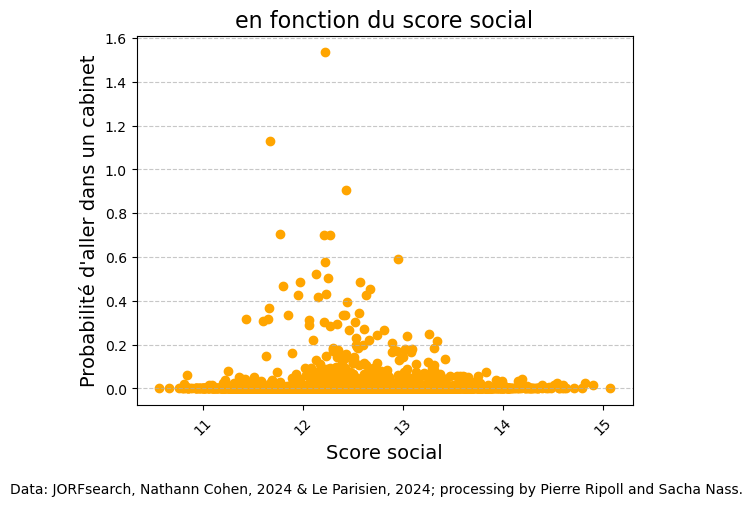

In [ ]:
plt.scatter(reg_2.score,reg_2.taux_nomination,color='orange')
plt.title("en fonction du score social", fontsize=16)
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024 & Le Parisien, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)  
plt.xlabel('Score social', fontsize=14)
plt.ylabel('Probabilité d\'aller dans un cabinet', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

## 3.2 Proportion de personnes avec le prénom dans un cabinet ministériel

On définit ici, la $\textit{probabilité}$ par la proportion des personnes du cabinet qui portent le prénom i.

In [ ]:
reg_score = tab_coul
reg_2 = pd.DataFrame(columns =["prenom","taux_nomination","score"])
reg_2.prenom = np.unique(reg_score.prenom)
## On va les passer en minuscule
for i in list(reg_2.prenom):
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms

## On va maintenant mettre le taux de nomination, avec 0 s'il n'a jamasi été nommé.

## On va enlever les accents des nomanitions ministérielles.

for i in list(np.unique(list(nominations_ministerielles.prenom))):
  nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"]=[unidecode(i)]*len(nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"])


for i in list(reg_2.prenom) :
  if i in list(np.unique(list(nominations_ministerielles.prenom))):
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/len(nominations_ministerielles) ## Cela donne le taux

  else :
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = 0
reg_2

/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single eleme

/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1706095093.py:6: FutureWarning: Calling float on a single eleme

prenom taux_nomination      score
0         Aaron               0  12.194332
1      Abdallah               0  11.575472
2         Abdel        0.000054  11.111554
3     Abdelaziz        0.000054  11.281553
4      Abdelhak               0       11.2
...         ...             ...        ...
3504   Zinedine               0  11.554264
3505      Ziyad               0  12.056604
3506        Zoe        0.000163  13.661697
3507      Zohra               0   11.85514
3508       Zora               0  13.370968

[3509 rows x 3 columns]

In [ ]:
Y = list(reg_2.taux_nomination)
X = list(reg_2.score)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.38
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00129
Time:                        20:22:26   Log-Likelihood:                 18615.
No. Observations:                3509   AIC:                        -3.723e+04
Df Residuals:                    3507   BIC:                        -3.721e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.000     -2.458      0.0

(array([10., 11., 12., 13., 14., 15., 16.]),
 [Text(10.0, 0, '10'),
  Text(11.0, 0, '11'),
  Text(12.0, 0, '12'),
  Text(13.0, 0, '13'),
  Text(14.0, 0, '14'),
  Text(15.0, 0, '15'),
  Text(16.0, 0, '16')])

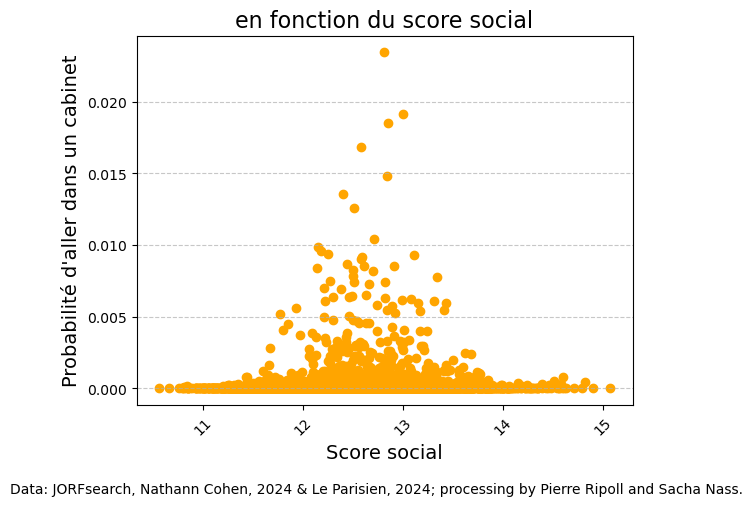

In [ ]:
plt.scatter(reg_2.score,reg_2.taux_nomination,color='orange')
plt.title("en fonction du score social", fontsize=16)
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024 & Le Parisien, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)  
plt.xlabel('Score social', fontsize=14)
plt.ylabel('Probabilité d\'aller dans un cabinet', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

## 3.3 Nouvelle définition du score social

Dans cette prénom nous allons redéfinir le $\textit{score}$ social comme la proportion de mention TB du prénom.

In [ ]:
## tab_coul2 est le tableau de M. Coulmon brut
MY_BUCKET = "pripoll"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/bac_ripoll.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    tab_coul2 = pd.read_csv(file_in).loc[:,"prenom":"total"]

tab_coul2= tab_coul2.pivot(columns= "mention", values = "N",index=["prenom","total"]).reset_index()

tab_coul2.columns = ["prenom","Nombre","nan","AB","B","Oral","Admis","SDF","TB"]
tab_coul2 = tab_coul2.drop(["nan","SDF"], axis=1)

tab_coul2 = tab_coul2.fillna(0)

tab_coul2["Score"] =tab_coul2["TB"]/tab_coul2["Nombre"]

tab_coul2 = tab_coul2.loc[pd.isnull(tab_coul2.prenom)==False,:]

tab_coul2 = tab_coul2[tab_coul2.Nombre >150]
tab_coul2 = tab_coul2.iloc[1:]

In [ ]:
reg_score = tab_coul2
reg_2 = pd.DataFrame(columns =["prenom","taux_nomination","score"])
reg_2.prenom = np.unique(reg_score.prenom)
## On va les passer en minuscule
for i in list(reg_2.prenom):
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms

## On va maintenant mettre le taux de nomination, avec 0 s'il n'a jamasi été nommé.

## On va enlever les accents des nomanitions ministérielles.

for i in list(np.unique(list(nominations_ministerielles.prenom))):
  nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"]=[unidecode(i)]*len(nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"])


for i in list(reg_2.prenom) :
  if i in list(np.unique(list(nominations_ministerielles.prenom))):
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/len(nominations_ministerielles) ## Cela donne le taux

  else :
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = 0

Y = list(reg_2.taux_nomination)
X = list(reg_2.score)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

/tmp/ipykernel_179646/1669129346.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1669129346.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1669129346.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_179646/1669129346.py:6: FutureWarning: Calling float on a single eleme

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.868
Date:                Fri, 20 Dec 2024   Prob (F-statistic):             0.0494
Time:                        20:22:54   Log-Likelihood:                 7662.1
No. Observations:                1551   AIC:                        -1.532e+04
Df Residuals:                    1549   BIC:                        -1.531e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   9.43e-05      4.010      0.0

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 [Text(-0.05, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.10000000000000002, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25000000000000006, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35')])

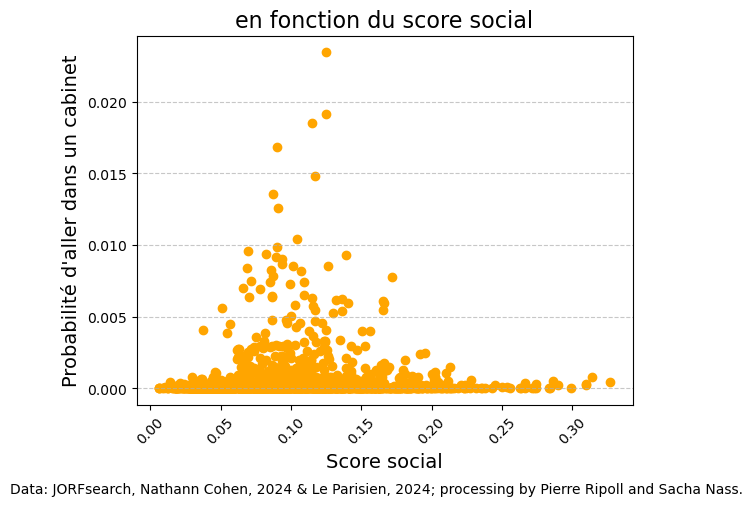

In [ ]:
plt.scatter(reg_2.score,reg_2.taux_nomination,color='orange')
plt.title("en fonction du score social", fontsize=16)
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024 & Le Parisien, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)  
plt.xlabel('Score social', fontsize=14)
plt.ylabel('Probabilité d\'aller dans un cabinet', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

## 3.3 Avec définition plus rigoureuse du nombre de personnes qui portent le nom i

Dans cette partie, nous allons refaire tourner la partie 3.1 mais en exploitant le fichier Insee pour mieux redéfinir la probabilité le "nombre de personnes qui portent le prénom i".
Pour cela on va importer le fichier nat2022.csv brut.

In [ ]:
### Importation 
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "pripoll"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/nat2022.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    nat = pd.read_csv(file_in,sep=";").loc[:,"sexe":"nombre"]
nat

sexe        preusuel annais  nombre
0          1  _PRENOMS_RARES   1900    1249
1          1  _PRENOMS_RARES   1901    1342
2          1  _PRENOMS_RARES   1902    1330
3          1  _PRENOMS_RARES   1903    1286
4          1  _PRENOMS_RARES   1904    1430
...      ...             ...    ...     ...
703002     2           ZYNEB   2019       7
703003     2           ZYNEB   2020       8
703004     2           ZYNEB   2021       6
703005     2           ZYNEB   2022       4
703006     2           ZYNEB   XXXX      19

[703007 rows x 4 columns]

In [ ]:
## Problème du fichier, les é sont écrits Ã‰ et les è Ãˆ
## On fait une boucle sur tous les prénoms pour vérifier si on trouve ces termes, et on remplacve par un E.

from unidecode import unidecode

def enlever_accents(chaine):
    return unidecode(chaine)
def chaine(cha):
    return str(cha)

nat.preusuel = nat.preusuel.apply(chaine)
nat.preusuel = nat.preusuel.apply(enlever_accents)

## On va maintenant filter sur les années
liste = list(map(str,list(range(1959,2020))))
nat = nat.loc[nat.annais.str.strip().isin(liste),:]

## On va maintenant groupby par prenom sur le modèle de ce quia été fait pour les scores

nat = nat.groupby(by = ["preusuel"]).sum().reset_index()
nat = nat.drop(["sexe","annais"],axis=1)
nat.to_csv("Nombre_pren.csv")
nat

preusuel   nombre
0                   A        6
1               AADAM       21
2               AADEL       28
3               AADIL      153
4               AAHIL       15
...               ...      ...
29711            ZYNA       41
29712           ZYNEB       92
29713            ZYON       11
29714  _PRENOMS_RARES  1361272
29715             nan        3

[29716 rows x 2 columns]

In [ ]:
## On va maintenant re-calculer le tableau de régression. reg_2 donne des prenoms sous forme nom propre sans accents, nat est au format majuscule sans accent.

reg_score = tab_coul2
reg_2 = pd.DataFrame(columns =["prenom","taux_nomination","score"])
reg_2.prenom = np.unique(reg_score.prenom)
## On va les passer en minuscule
for i in list(reg_2.prenom):
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms

## On va maintenant mettre le taux de nomination, avec 0 s'il n'a jamasi été nommé.

## On va enlever les accents des nomanitions ministérielles.

for i in list(np.unique(list(nominations_ministerielles.prenom))):
  nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"]=[unidecode(i)]*len(nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"])


for i in list(reg_2.prenom) :
  if i in list(np.unique(list(nominations_ministerielles.prenom))):
    if len(nat.loc[nat.preusuel == i.upper(),"nombre"]) !=0:
        reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/float(nat.loc[nat.preusuel == i.upper(),"nombre"]) ## Cela donne le taux
    else : ## Si pas dans fichier Insee (prenom rare), reprendre l'ancienne def
        reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/float(reg_score.loc[reg_score.prenom == i,"Nombre"])
  else :
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = 0

Y = list(reg_2.taux_nomination)
X = list(reg_2.score)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

/tmp/ipykernel_177867/2644788634.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_177867/2644788634.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_177867/2644788634.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_177867/2644788634.py:8: FutureWarning: Calling float on a single eleme

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     60.32
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.46e-14
Time:                        20:08:16   Log-Likelihood:                 9535.0
No. Observations:                1551   AIC:                        -1.907e+04
Df Residuals:                    1549   BIC:                        -1.906e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.153e-05   2.82e-05      1.829      0.0

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 [Text(-0.05, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.10000000000000002, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25000000000000006, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35')])

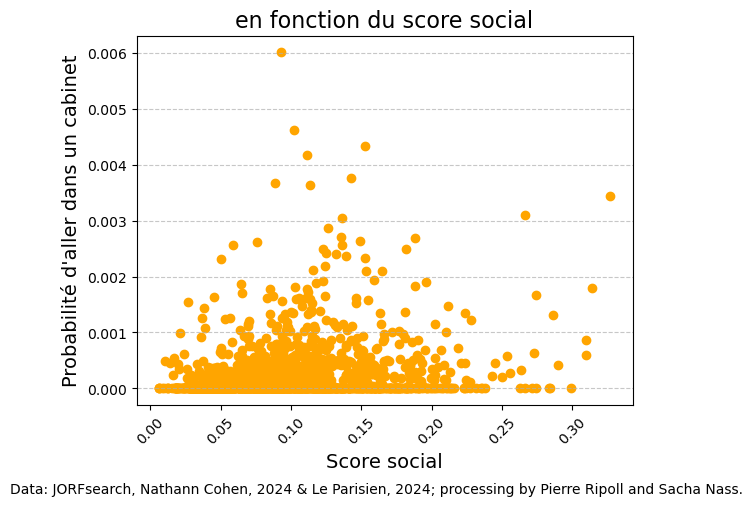

In [ ]:
plt.scatter(reg_2.score,reg_2.taux_nomination,color='orange')
plt.title("en fonction du score social", fontsize=16)
plt.suptitle("Data: JORFsearch, Nathann Cohen, 2024 & Le Parisien, 2024; processing by Pierre Ripoll and Sacha Nass.", fontsize=10, y=-0.05)  
plt.xlabel('Score social', fontsize=14)
plt.ylabel('Probabilité d\'aller dans un cabinet', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

## 3.4 Avec terme d'intéraction avec le genre

On va maintenant inclure l'intéraction avec une variable genre. Pour cela on va coupler régresser selon les variables socre social, le genre et faire les interractions. On va pour cela utiliser les données de genre du Jorf, et dans les cas limites on prend le sexe tel qu'indiqué dans le document Insee. Variable booléenne.


In [ ]:
MY_BUCKET = "pripoll"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/nat2022.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    sex_pren = pd.read_csv(file_in,sep=";").loc[:,"sexe":"nombre"]

sex_pren.preusuel = sex_pren.preusuel.apply(chaine)
sex_pren.preusuel = sex_pren.preusuel.apply(enlever_accents)

sex_pren = sex_pren.drop(["annais","nombre"],axis = 1).drop_duplicates()
sex_pren.to_csv("pren_sex.csv")

In [ ]:
sex_pren

sexe        preusuel
0          1  _PRENOMS_RARES
123        1               A
126        1           AADAM
135        1           AADEL
143        1           AADIL
...      ...             ...
702929     2            ZURI
702933     2         ZUZANNA
702953     2             ZYA
702976     2            ZYNA
702988     2           ZYNEB

[35850 rows x 2 columns]

In [ ]:
import statsmodels.formula.api as smf

## On va maintenant re-calculer le tableau de régression. reg_2 donne des prenoms sous forme nom propre sans accents, nat est au format majuscule sans accent.

reg_score = tab_coul2
reg_2 = pd.DataFrame(columns =["prenom","taux_nomination","score","sexe"])
reg_2.prenom = np.unique(reg_score.prenom)

## On va les passer en minuscule
for i in list(reg_2.prenom):
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms

## On va maintenant mettre le taux de nomination, avec 0 s'il n'a jamasi été nommé.

## On va enlever les accents des nomanitions ministérielles.

for i in list(np.unique(list(nominations_ministerielles.prenom))):
  nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"]=[unidecode(i)]*len(nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"prenom"])


for i in list(reg_2.prenom) :
  if i in list(np.unique(list(nominations_ministerielles.prenom))):
    reg_2.loc[reg_2.prenom==i, "sexe"] = str(nominations_ministerielles.loc[nominations_ministerielles.prenom ==i,"sexe"].iloc[0])

    if len(nat.loc[nat.preusuel == i.upper(),"nombre"]) !=0:
        reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/float(nat.loc[nat.preusuel == i.upper(),"nombre"]) ## Cela donne le taux
    else : ## Si pas dans fichier Insee (prenom rare), reprendre l'ancienne def
        reg_2.loc[reg_2.prenom==i, "taux_nomination"] = count_occurrences(nominations_ministerielles.prenom,i)/float(reg_score.loc[reg_score.prenom == i,"Nombre"])
  else :
    if i.upper() in list(sex_pren.preusuel):
      reg_2.loc[reg_2.prenom==i, "sexe"] = int(sex_pren.loc[sex_pren.preusuel == i.upper(),"sexe"].iloc[0])-1
    else :
      reg_2.loc[reg_2.prenom==i, "sexe"] = 0.5 ## On tranche en mettant la moitié dans les cas limites
    reg_2.loc[reg_2.prenom==i, "taux_nomination"] = 0
  

def trans_sexe(ch):
  if type(ch)!=int :
    if ch == "M":
      return 0
    else:
      return 1
  else:
    return ch

reg_2.sexe = reg_2.sexe.apply(trans_sexe)
def nombre(nb):
    return float(nb)

reg_2.taux_nomination = reg_2.taux_nomination.apply(nombre)

formula = "taux_nomination ~ sexe*score"
model = smf.ols(formula=formula, data=reg_2).fit()

print(model.summary())

/tmp/ipykernel_181857/3330632499.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_181857/3330632499.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_181857/3330632499.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reg_2.loc[reg_2.prenom ==i,"score"] = float(reg_score.loc[reg_score.prenom == i,"Score"]) ## On met le score des prenoms
/tmp/ipykernel_181857/3330632499.py:11: FutureWarning: Calling float on a single e

prenom taux_nomination     score sexe
0          Aaron               0  0.076923    0
1       Abdallah               0   0.04717    0
2          Abdel        0.000234  0.015936    M
3     Abdelkader               0  0.009967    0
4      Abdoulaye               0  0.018405    0
...          ...             ...       ...  ...
1546      Zeynep               0   0.03012    1
1547       Zineb        0.001235  0.053459    F
1548    Zinedine               0   0.01938    0
1549         Zoe        0.000048  0.182878    F
1550       Zohra               0  0.051402    1

[1551 rows x 4 columns]

Le $R^2$ est légèrement plus élevé.
La p-valeur associée au score est excellente, ce qui assure que le coefficient théorique de $score$ est non nul.
La p-valeur associée à sexe est aussi assez bonne, le coefficient négatif indique que toutes choses égales par ailleurs être un homme augmente la probabilité d'accéder aux cabinets ministériels. Cela va dans le sens dans le signe du terme croisé sexe:score qui indique qu'à $score$ fixé, être un homme donne une plus grande probabilité d'accéder aux cabinets ministériels. Cependant, la p-value de cette variable est assez mauvaise ce qui crée une forte incertitude sur la véracité de l'effet croisé.